In [73]:
#import nessecary libraries
import numpy as np
from PIL import Image, ImageFont, ImageDraw
from skimage import io, filters
import matplotlib.pyplot as plt
from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
from IPython.display import display
import cv2
from skimage.filters import try_all_threshold
from skimage import data
from skimage.filters import threshold_li
from skimage.feature import canny
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
import skimage as ski
from skimage.measure import label, regionprops



In [74]:
#Outline
#1. use the multicompartiment model to segment glomeruli or anotate using imagescope
#2. use tiffslide to open the regions
#3. view the thumbnails
#4. turn gray
#5. threshold
#6. inverse
#7. identify areas and overlay the podocyte images
#8. overlay to the bigger image


In [3]:
import xml.etree.ElementTree as ET
from tiffslide import TiffSlide
from xml.dom import minidom
slide = TiffSlide('./Images/p57.svs')
print("Amen")
    


Amen


In [35]:
import tiffslide
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_li
from lxml import etree



# File paths
slide_path = './Images/p57.svs'  # Add the path to your whole slide image
xml_path = './Images/p57.xml'






In [36]:
def parse_xml(xml_file):
    try:
        tree = etree.parse(xml_file)
        root = tree.getroot()
       # print(etree.tostring(root, pretty_print=True).decode())  # Print the XML structure for debugging
        tiles = []
        for region in root.findall('.//Region'):
            vertices = region.findall('.//Vertex')
            if len(vertices) < 4:
                print("Error: Less than 4 vertices found")
                continue
            x_coords = [float(vertex.get('X')) for vertex in vertices]
            y_coords = [float(vertex.get('Y')) for vertex in vertices]
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            width = int(x_max - x_min)
            height = int(y_max - y_min)
            tiles.append((int(x_min), int(y_min), width, height))
        return tiles
    except Exception as e:
        print(f"Error parsing XML file: {e}")
        return []
tiles = parse_xml(xml_path)
#print(tiles)


Processing tile at (8697, 17046) with size (306x269)


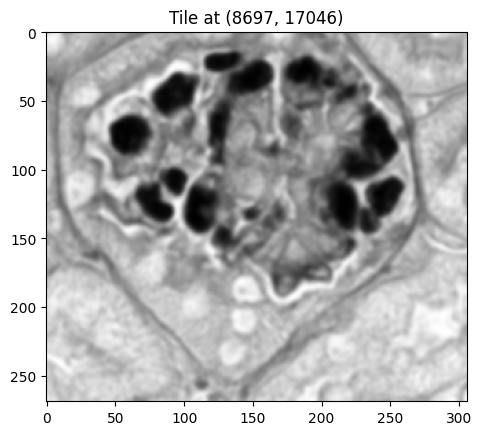

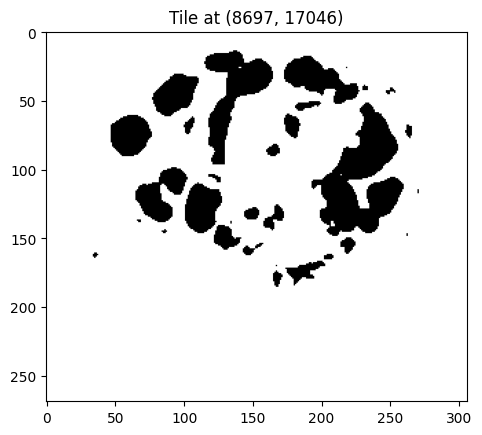

Processing tile at (8438, 16691) with size (296x312)


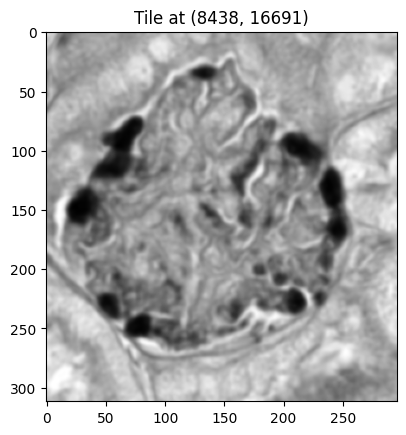

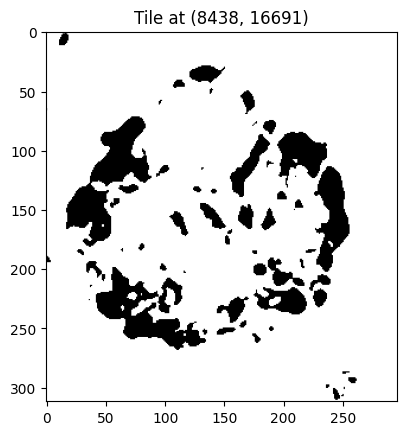

Processing tile at (8126, 16607) with size (285x280)


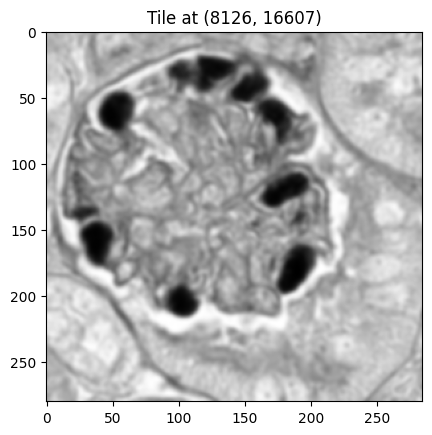

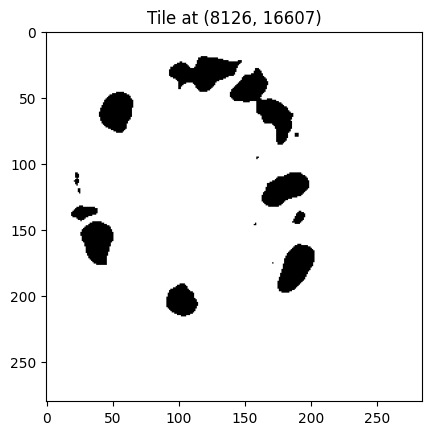

In [59]:
# Function to extract and threshold tiles
def process_tiles(slide, tiles):
    thresh_tiles=[]
    for (x, y, width, height) in tiles:
        print(f"Processing tile at ({x}, {y}) with size ({width}x{height})")
        tile = slide.read_region((x, y), 0, (width, height)).convert("RGB")
        tile_array = np.array(tile)
        tile_array= filters.gaussian(tile_array, sigma=1.3)
        gray_tile = np.dot(tile_array[..., :3], [0.2989, 0.5870, 0.1140])  # Convert to grayscale
        li_thresh = threshold_li(gray_tile)
        binary_tile = gray_tile > li_thresh
        plt.figure()
        plt.title(f"Tile at ({x}, {y})")
        plt.imshow(gray_tile, cmap='gray')
        plt.show()
        
        
        plt.figure()
        plt.title(f"Tile at ({x}, {y})")
        plt.imshow(binary_tile, cmap='gray')
        plt.show()
        thresh_tiles.append(binary_tile)
    return thresh_tiles
thresh_tiles = process_tiles(slide, tiles)


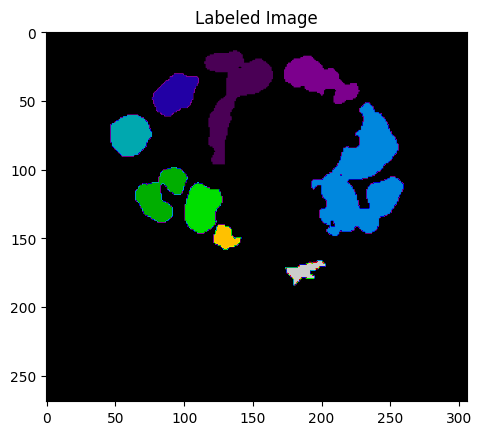

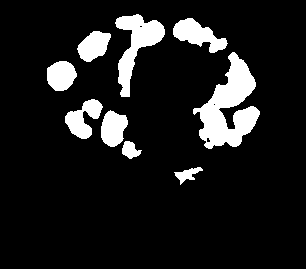

The number of podocytes in this image is: 9


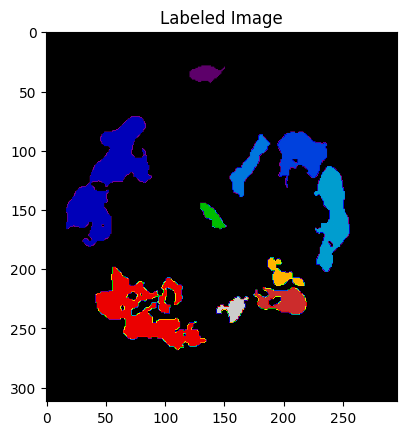

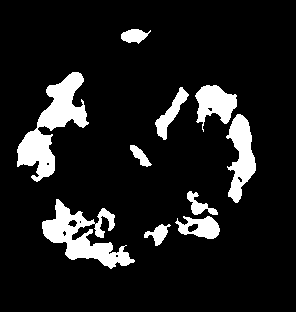

The number of podocytes in this image is: 10


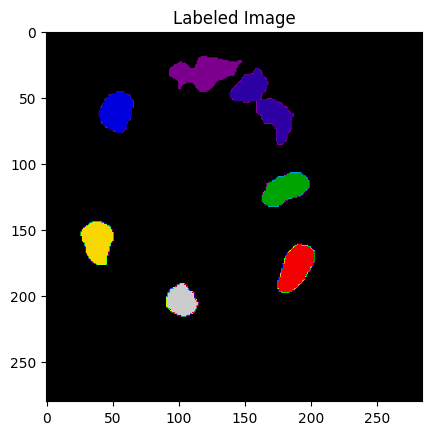

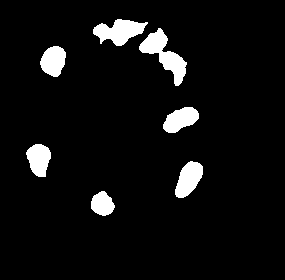

The number of podocytes in this image is: 7


In [83]:
for im_thresh in thresh_tiles:
    im_thresh= np.array(im_thresh)                  #read it as a numpy array
    im_thresh_inv= ski.util.invert(im_thresh)          #invert the image
    label_image = label(im_thresh_inv)                 # label the regions
   
    for region in regionprops(label_image):                          #label the areas
        if region.area < 200:
            for coordinates in region.coords:
                label_image[coordinates[0], coordinates[1]] = 0
    im_thresh_inv_arr = label_image > 0
    Podocount = 0
    for region in regionprops(label_image):
        Podocount +=1                                  #Count Podocytes
    # check if it is labeling correctly  for debugging purposes
    plt.imshow(label_image, cmap='nipy_spectral')
    plt.title('Labeled Image')

    plt.show()
    cleanIm = Image.fromarray(im_thresh_inv_arr)
    display(cleanIm)
    print("The number of podocytes in this image is:", Podocount)

In [ ]:
#Next step

#produce an overlay image

#Notes

#Use Moprhological operations maybe erosion to make it more efficient
#Maybe use color deconvolution for the three circles inside